# Get Data

In [2]:
import numpy as np

from six.moves import urllib
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
    print("Obtained mnist_784")
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST_original')
    print("Obtained MNIST_original")

Obtained mnist_784


In [3]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

# PCA on MNIST

In [3]:
from sklearn.decomposition import PCA

# Compress to 95% retention
pca = PCA(n_components=0.95)
X_compressed = pca.fit_transform(X_train)

In [4]:
print(pca.n_components_)
print(np.sum(pca.explained_variance_ratio_))

154
0.9503227301049725


In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

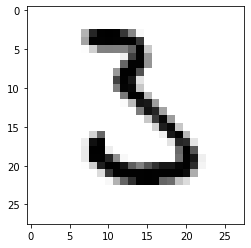

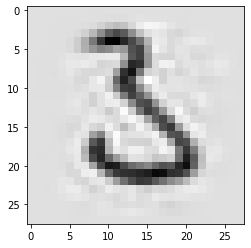

In [6]:
size = 28
plt.imshow(X_train[0].reshape(size, size), cmap = mpl.cm.binary)
plt.figure()
plt.imshow(pca.inverse_transform(X_compressed[0]).reshape(size, size), cmap = mpl.cm.binary)


## See heavier compression


30
0.7315520451740353


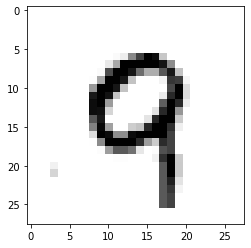

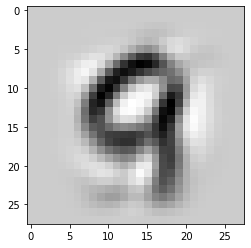

In [7]:
pca = PCA(n_components=30)
X_compressed = pca.fit_transform(X_train)
print(pca.n_components_)
print(np.sum(pca.explained_variance_ratio_))
size = 28
plt.imshow(X_train[1].reshape(size, size), cmap = mpl.cm.binary)
plt.figure()
plt.imshow(pca.inverse_transform(X_compressed[1]).reshape(size, size), cmap = mpl.cm.binary)


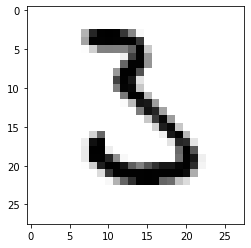

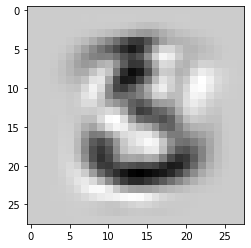

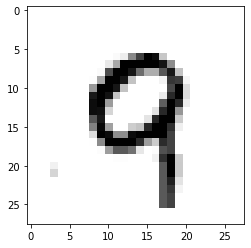

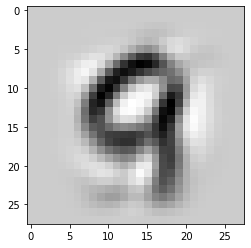

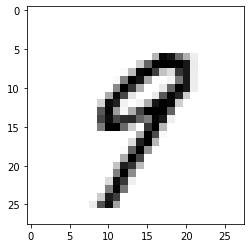

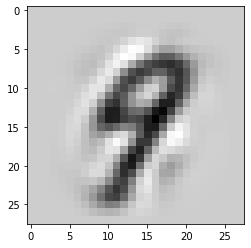

In [8]:
for i in range(3):
    plt.figure()
    plt.imshow(X_train[i].reshape(size, size), cmap = mpl.cm.binary)
    plt.figure()
    plt.imshow(pca.inverse_transform(X_compressed[i]).reshape(size, size), cmap = mpl.cm.binary)


## Random number back generation

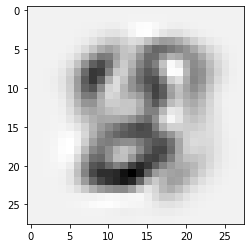

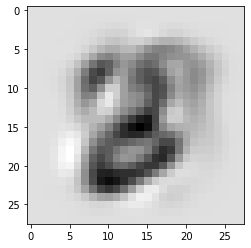

In [9]:
# Random back generation

for i in range(2):
    plt.figure()
    plt.imshow(pca.inverse_transform(np.random.rand(X_compressed[i].shape[0])*300).reshape(size, size), cmap = mpl.cm.binary)


# Random Forest Before PCA

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10)

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
import time
t0_train = time.time()
rfc.fit(X_train, y_train)
t1_train = time.time()

In [13]:
t0_test = time.time()
y_pred = rfc.predict(X_test)
t1_test = time.time()
acc = accuracy_score(y_test, y_pred)


In [14]:
print("Training took {:.2f} seconds".format(t1_train - t0_train))
print("Prediction took {:.2f} seconds".format(t1_test-t0_test))
print("Accuracy {:.2f}%".format(acc*100))

Training took 5.11 seconds
Prediction took 0.14 seconds
Accuracy 94.51%


# Random Forest After PCA

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.95)
t0_pca_train = time.time()
X_train_low_dim = pca.fit_transform(X_train)
t1_pca_train = time.time()

In [16]:
t0_rfc_train = time.time()
rfc.fit(X_train_low_dim, y_train)
t1_rfc_train = time.time()

In [17]:
t0_pca_test = time.time()
X_test_low_dim = pca.transform(X_test)
t1_pca_test = time.time()

In [18]:
t0_rfc_test = time.time()
y_pred = rfc.predict(X_test_low_dim)
t1_rfc_test = time.time()
acc = accuracy_score(y_test, y_pred)

In [19]:
print("Training took {:.2f} seconds (not counting PCA time)".format(t1_rfc_train - t0_rfc_train))
print("Prediction took {:.2f} seconds (Not counting PCA time)".format(t1_rfc_test-t0_rfc_test))
print("Accuracy {:.2f}%".format(acc*100))

Training took 10.93 seconds (not counting PCA time)
Prediction took 0.31 seconds (Not counting PCA time)
Accuracy 88.49%


### So we had a slowdown in training AND a reduction in accuracy -- dimensionality reduction does not always help

# t-SNE on MNIST for Visualization

In [4]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
reduced = 5000
X_train_smaller = X_train[:reduced]
y_train_smaller = y_train[:reduced]
test_reduced = 2000
X_test_smaller = X_test[:test_reduced]
y_test_smaller = y_test[:test_reduced]

X_post_tsne = tsne.fit_transform(X_train_smaller)


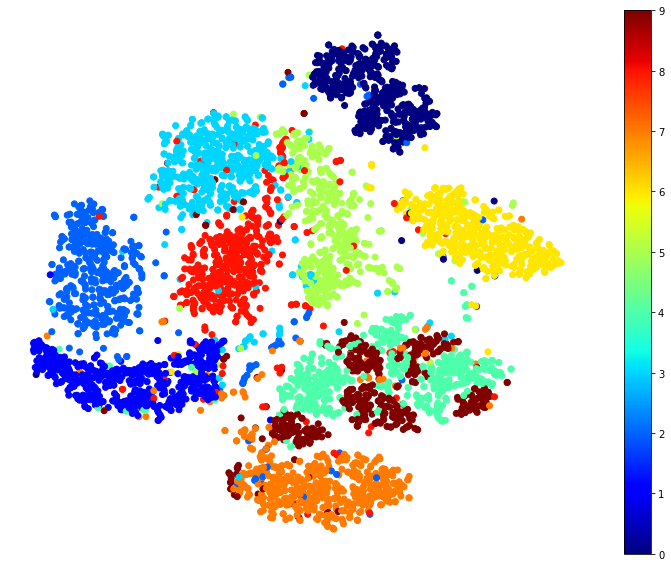

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.axis("off")
scatter = plt.scatter(X_post_tsne[:,0], X_post_tsne[:,1],c=y_train_smaller, cmap="jet")

plt.colorbar()
# plt.legend(handles=scatter.legend_elements()[0], labels = range(10))
plt.show()

### Here we can see that 0, 1, 2, 6, and 7 are really easily distinguishable from others, as they form very contained and seperate clusters. However, it seems like 5s and 3s are hard to distinguish, as are 9s and 4s, as we can see that thier clusters aren't as easy to seperate.

### Lets look at 9 and 4 in more detail and see if we can get nicer visualization

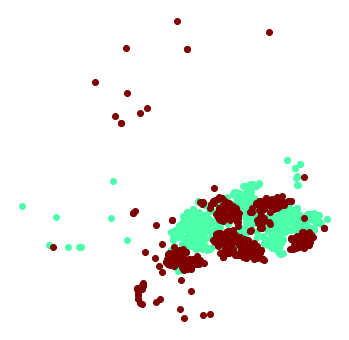

In [19]:
import matplotlib as mpl

plt.figure(figsize=(6,6))
cmap = mpl.cm.get_cmap("jet")
for digit in (4, 9):
    plt.scatter(X_post_tsne[y_train_smaller == digit, 0], X_post_tsne[y_train_smaller == digit, 1], c=[cmap(digit/9)])
plt.axis("off")
plt.show()    

### Lets run r-SNE on just these two digits

In [14]:
idx = (y_train_smaller == 4) | (y_train_smaller == 9)
X_subset = X_train_smaller[idx]
y_subset = y_train_smaller[idx]

tsne_subset = TSNE(n_components=2)
X_subset_post_tsne = tsne_subset.fit_transform(X_subset)

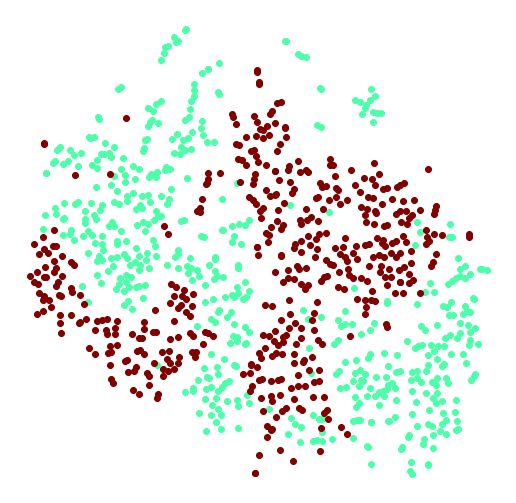

In [15]:
plt.figure(figsize=(9,9))
for digit in (4, 9):
    plt.scatter(X_subset_post_tsne[y_subset == digit, 0], X_subset_post_tsne[y_subset == digit, 1], c=[cmap(digit/9)])
plt.axis("off")
plt.show()    

# Random Forest After t-SNE (on reduced set)(failed)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
rfc = RandomForestClassifier(n_estimators=10)

t0 = time.time()
rfc.fit(X_train_smaller, y_train_smaller)
t1 = time.time()

y_pred = rfc.predict(X_test_smaller)
acc = accuracy_score(y_test_smaller, y_pred)

print("Training time {:.2f}".format(t1-t0))
print("Accuracy {:.2f}".format(acc*100))

Training time 0.29
Accuracy 89.25


In [7]:
t0 = time.time()
rfc.fit(X_post_tsne, y_train_smaller)
t1 = time.time()

y_pred = rfc.predict(tsne.fit_transform(X_test_smaller))
acc = accuracy_score(y_test_smaller, y_pred)

print("Training time {:.2f}".format(t1-t0))
print("Accuracy {:.2f}".format(acc*100))

Training time 0.09
Accuracy 14.80


### Realized at this point the t-SNE does not have a "transform" function, but rather only a tranform_fit, so the initial expirement would fail, as its a different dimensionality reduction happening during train vs test

# Attempting 3D t-SNE

In [20]:
tsne = TSNE(n_components=3)
reduced = 5000
X_train_smaller = X_train[:reduced]
y_train_smaller = y_train[:reduced]
test_reduced = 2000
X_test_smaller = X_test[:test_reduced]
y_test_smaller = y_test[:test_reduced]

X_post_tsne = tsne.fit_transform(X_train_smaller)

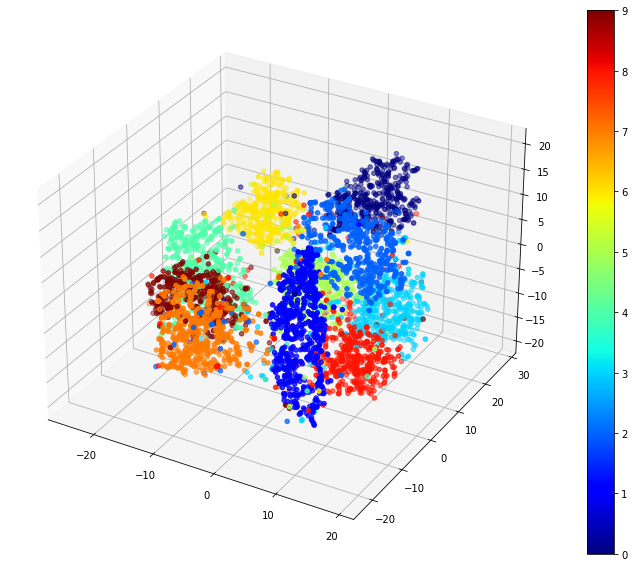

In [67]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(X_post_tsne[:,0], X_post_tsne[:,1], X_post_tsne[:,2], c=y_train_smaller, cmap="jet")

fig.colorbar(p)
plt.show()

# PCA on MNIST for visualization

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2dim = pca.fit_transform(X_train)
print(np.sum(pca.explained_variance_ratio_))


0.16885841549306135


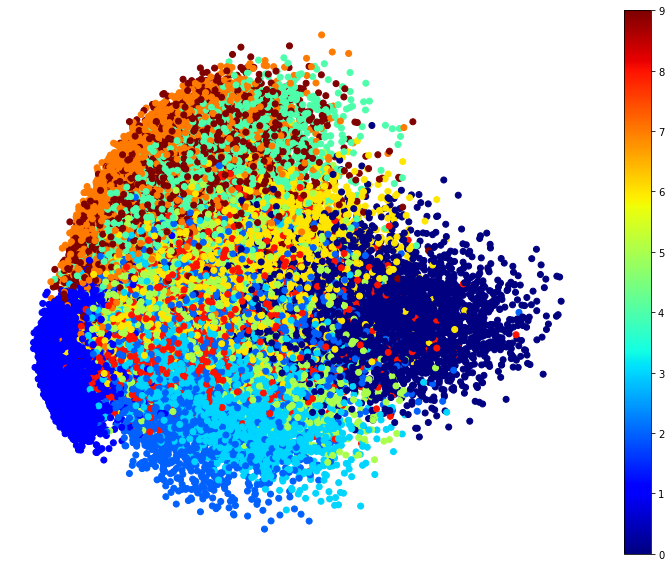

In [53]:
plt.figure(figsize=(13,10))
plt.axis('off')
plt.scatter(X_2dim[:,0], X_2dim[:,1], c=y_train, cmap="jet")
plt.colorbar()
plt.show()

In [54]:
pca = PCA(n_components=3)
X_3dim = pca.fit_transform(X_train)
print(np.sum(pca.explained_variance_ratio_))

0.23003500407389893


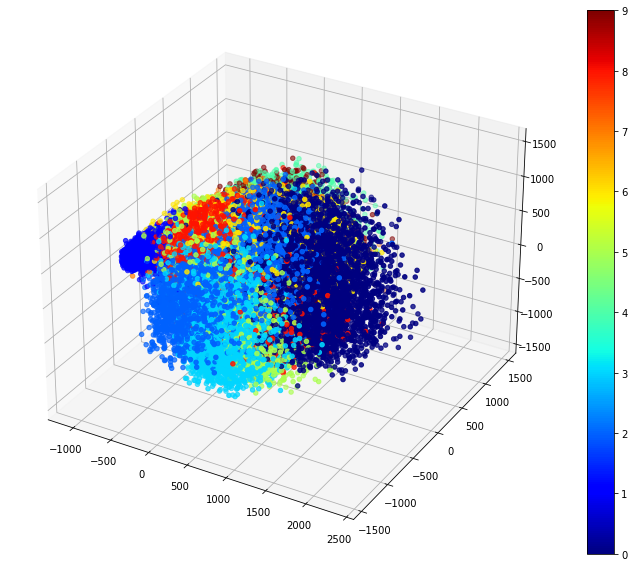

In [65]:
fig = plt.figure(figsize=(13,10))

ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(X_3dim[:,0], X_3dim[:,1], X_3dim[:,2], c=y_train, cmap="jet")
fig.colorbar(p)

plt.show()

### So it seems like PCA is not as great for visulaizing as t-SNE was, although there is some apparent clustering that happens. However, one thing is that PCA was MAGNITUDES faster than t-SNE. 